### Using CIR to model the change in int rate, an extention of popular Vasicek model to prevent negative int rate

In [5]:
# CIR - cox ingersoll ross model (mean reverting + shock[dWt] model)

In [6]:
# 1+r(annual)=e^r(instant)
# r(int)=in(1+r[annual])

In [75]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
def inst_to_ann(r):
    """convert short rate to annualized rate"""
    return np.expm1(r)
## m1 means minus 1

In [77]:
def ann_to_inst(r):
    """convert ann rate to short rate"""
    return np.log1p(r)
# 1p means plus 1

In [78]:
def cir0(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """implement CIR for int rate, a is speed to revert, b is LT mean"""
    if r_0 is None: r_0=b
    r_0=ann_to_inst(r_0)
    dt=1/steps_per_year
    # sacle is the sigma
    num_steps=int(n_years*steps_per_year)+1
    # plus 1 because we want to initialize array of rates, contain initial rate at row 0
    shock=np.random.normal(0,scale=np.sqrt(dt),size=(num_steps,n_scenarios))
    rates=np.empty_like(shock)
    rates[0]=r_0
    # start with 1 because we already filled 0 with r_0
    for step in range(1,num_steps):
        # d_rt is the change in rate
        r_t=rates[step-1]
        d_r_t=a*(b-r_t)*dt+sigma*np.sqrt(r_t)*shock[step]
        rates[step]=abs(r_t+d_r_t)
    return pd.DataFrame(data=inst_to_ann(rates),index=range(num_steps))

In [79]:
%matplotlib inline

<AxesSubplot:>

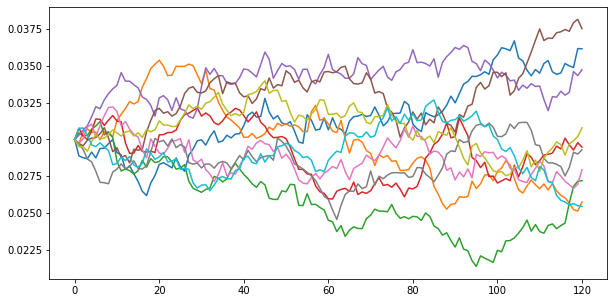

In [80]:
cir0(n_scenarios=10, sigma=0.01).plot(figsize=(10,5),legend=False)

## the price of a ZC bond will eventually converge to one price at maturiaty (although there will be fluctuation in process as int rate changes)

In [81]:
import math
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """implement CIR for int rate, a is speed to revert, b is LT mean"""
    if r_0 is None: r_0=b
    r_0=ann_to_inst(r_0)
    dt=1/steps_per_year
    # sacle is the sigma
    num_steps=int(n_years*steps_per_year)+1
    # plus 1 because we want to initialize array of rates, contain initial rate at row 0
    shock=np.random.normal(0,scale=np.sqrt(dt),size=(num_steps,n_scenarios))
    rates=np.empty_like(shock)
    rates[0]=r_0
    ## for price generation
    h=math.sqrt(a**2+2*sigma**2)
    prices=np.empty_like(shock)
    
    def price(ttm,r):
        _A=((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B=(2*(math.exp(h*ttm)-1))/(2*h+(h+a)*(math.exp(h*ttm)-1))
        _P=_A*np.exp(-_B*r)
        return _P
    prices[0]=price(n_years,r_0)
    # start with 1 because we already filled 0 with r_0
    for step in range(1,num_steps):
        # d_rt is the change in rate
        r_t=rates[step-1]
        d_r_t=a*(b-r_t)*dt+sigma*np.sqrt(r_t)*shock[step]
        rates[step]=abs(r_t+d_r_t)
        ## generating price at time t as well
        prices[step]=price(n_years-step*dt,rates[step])
    rates=pd.DataFrame(data=inst_to_ann(rates),index=range(num_steps))
    prices=pd.DataFrame(data=prices,index=range(num_steps))
    return rates, prices

In [82]:
# use ZC bond as hedge VS use cash as hedge

In [83]:
a_0=0.75
rates,bond_prices=cir(n_years=10,r_0=0.03,b=0.03,n_scenarios=10)
# model liability just as change in ZC bond price (as int rate changes)
liabilities=bond_prices
# [1] [10] means paying off 1 dollor, in 10 years
zcbond_10=pd.Series(data=[1],index=[10])
zc_0=erk.pv(zcbond_10,r=0.03)
n_bonds=a_0/zc_0
av_zc_bonds=n_bonds*bond_prices
av_cash=a_0*(rates/12+1).cumprod()

<AxesSubplot:>

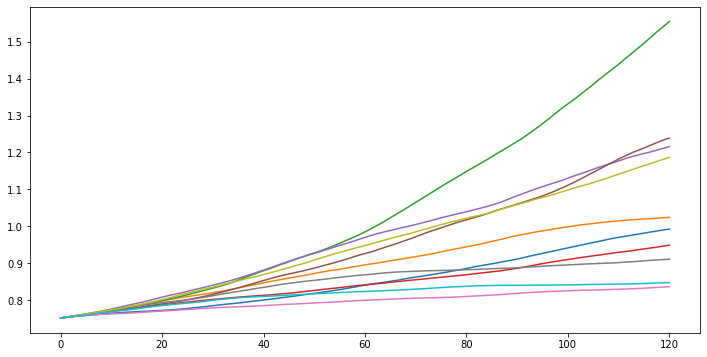

In [84]:
av_cash.plot(figsize=(12,6),legend=False)

In [85]:
# if at maturity, the cash exceeds 1, you succeed because you can meet your then liability,
# however, if less than 1, we are short

<AxesSubplot:>

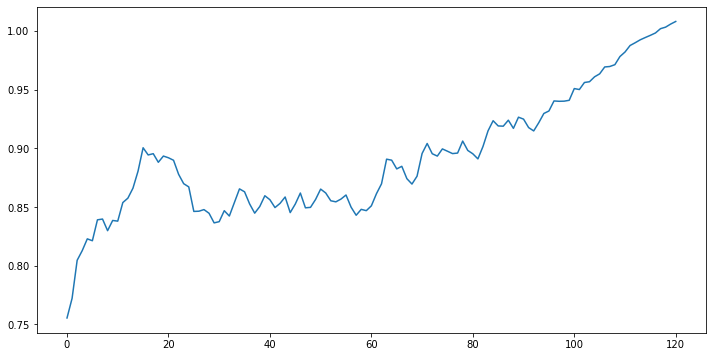

In [86]:
av_zc_bonds.plot(figsize=(12,6),legend=False)

In [87]:
# beauty of zc bond, end sighly above 1

<AxesSubplot:title={'center':'Returns of funding ratio with cash (10 scenarios)'}>

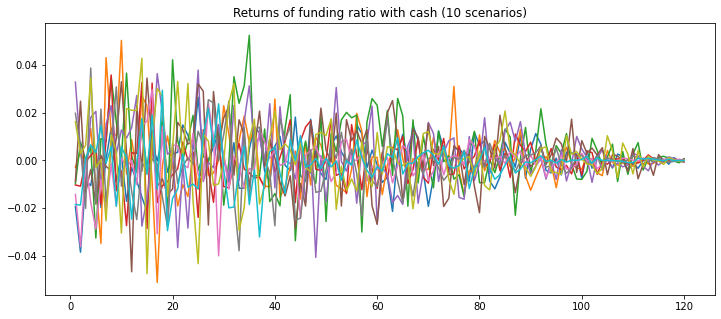

In [88]:
# funding ratio using cash as asset is very volatile:
((av_cash)/liabilities).pct_change().plot(title='Returns of funding ratio with cash (10 scenarios)',legend=False,figsize=(12,5))

                                                                                                                    

<AxesSubplot:title={'center':'Returns of funding ratio with zc bond (10 scenarios)'}>

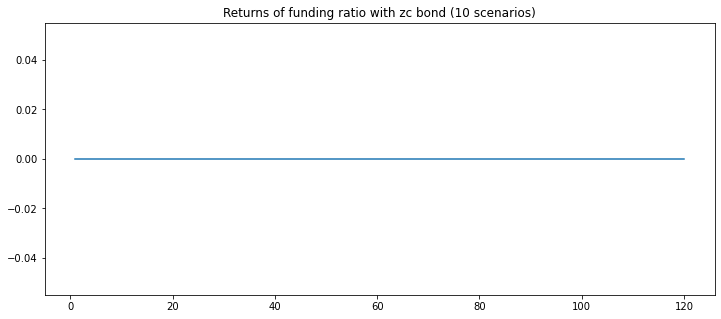

In [89]:
((av_zc_bonds)/liabilities).pct_change().plot(title='Returns of funding ratio with zc bond (10 scenarios)',legend=False,figsize=(12,5))

In [90]:
# use zc bond as funding hedge, we get a flat funding ratio
# zc bond is less sensitive to int rate fluctuation

In [93]:
a_0=0.75
rate,bond_prices=erk.cir(n_scenarios=10000,r_0=0.03,b=0.03)
liabilities=bond_prices
zcbond_10=pd.Series(data=[1],index=[10])
zc_0=erk.pv(zcbond_10,r=0.03)
n_bonds=a_0/zc_0
av_zc_bonds=n_bonds*bond_prices
av_cash=a_0*((rates/12)+1).cumprod()

<AxesSubplot:label='e3c4efa5-a91f-47f1-962a-509ec3bf5428'>

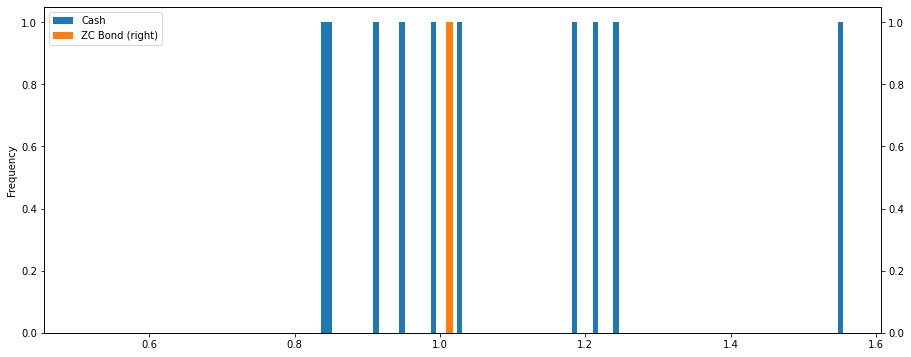

In [99]:
# now look at terminal funding ratio
tfr_cash=av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds=av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax=tfr_cash.plot.hist(label='Cash',figsize=(15,6),bins=100,legend=True)
tfr_zc_bonds.plot.hist(ax=ax,label='ZC Bond',bins=100,legend=True,secondary_y=True)

In [71]:
#funding ratio of zc bond is rock solid, pension fund can keep promise